In [100]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn import model_selection, metrics
from lightgbm import LGBMClassifier
import lightgbm
import os

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/crosssell-prediction/train.csv_VsW9EGx/train.csv
/kaggle/input/crosssell-prediction/test.csv_yAFwdy2/test.csv


In [101]:
train = pd.read_csv('../input/crosssell-prediction/train.csv_VsW9EGx/train.csv', index_col = 'id')
test = pd.read_csv('../input/crosssell-prediction/test.csv_yAFwdy2/test.csv', index_col = 'id')

In [102]:
le = LabelEncoder()

train['Gender'] = le.fit_transform(train['Gender'])
test['Gender'] = le.transform(test['Gender'])

train['Vehicle_Age'] = le.fit_transform(train['Vehicle_Age'])
test['Vehicle_Age'] = le.transform(test['Vehicle_Age'])

train['Vehicle_Damage'] = le.fit_transform(train['Vehicle_Damage'])
test['Vehicle_Damage'] = le.transform(test['Vehicle_Damage'])

In [103]:
predictors = ['Gender', 'Age', 'Driving_License', 'Region_Code', 'Previously_Insured',
       'Vehicle_Age', 'Vehicle_Damage', 'Annual_Premium',
       'Policy_Sales_Channel', 'Vintage']

predictors = predictors + ['Previously_Insured_*_Vehicle_Damage', 'Previously_Insured_+_Vehicle_Damage']


train['Previously_Insured_*_Vehicle_Damage'] = train['Previously_Insured'] * train['Vehicle_Damage']
test['Previously_Insured_*_Vehicle_Damage'] = test['Previously_Insured'] * test['Vehicle_Damage']

train['Previously_Insured_+_Vehicle_Damage'] = train['Previously_Insured'] + train['Vehicle_Damage']
test['Previously_Insured_+_Vehicle_Damage'] = test['Previously_Insured'] + test['Vehicle_Damage']



In [104]:
target = 'Response'


def modelfit(alg, dtrain, dtest, predictors, target, filename):
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], dtrain[target])
    print("Fit Done")   
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
    print("Predict Done")

    #Perform cross-validation:
    cv_score = model_selection.cross_val_score(alg, dtrain[predictors], dtrain[target], scoring = 'roc_auc')
    
    #Print model report:
    print("\nModel Report")
    print("ACC : %.4g" % metrics.roc_auc_score(dtrain[target].values, dtrain_predictions))
    print("CV Score : Mean - %.6g | Std - %.6g | Min - %.6g | Max - %.6g" % (np.mean(cv_score),np.std(cv_score),np.min(cv_score),np.max(cv_score)))
    
    #Predict on testing data:
    predicted = alg.predict_proba(dtest[predictors])
    #Export submission file:
    li = list(predicted[:, 1])
    submission = pd.DataFrame({ 'id': list(dtest.index), 'Response': li})
    submission.to_csv(filename, index=False)

Fit Done
Predict Done

Model Report
ACC : 0.5027
CV Score : Mean - 0.858013 | Std - 0.000953324 | Min - 0.856886 | Max - 0.859232


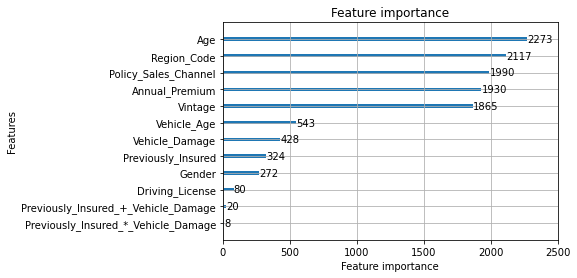

In [105]:
alg1 = LGBMClassifier(learning_rate = 0.03, max_depth = 100, n_estimators = 395, objective = 'binary', boosting_type = 'gbdt')
modelfit(alg1, train, test, predictors, target, './sub1.csv')
lightgbm.plot_importance(alg1)